In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm


from unet import UNet
from Diffusion import DenoiseDiffusion



In [2]:
def setup_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def setup_configuration():
    return {
        "image_size": 128,
        "image_channels": 1,
        "n_channels": 64,
        "channel_multipliers": [1, 2, 2, 4],
        "is_attention": [False, False, False, True],
        "n_steps": 1000,
        "batch_size": 40,
        "n_samples": 16,
        "learning_rate": 1e-4,
        "epochs": 10
    }

In [3]:
def setup_models_and_optimizer(config, device):
    eps_model = UNet(
        image_channels=config["image_channels"],
        n_channels=config["n_channels"],
        ch_mults=config["channel_multipliers"],
        is_attn=config["is_attention"]
    ).to(device)

    diffusion_model = DenoiseDiffusion(
        eps_model=eps_model,
        n_steps=config["n_steps"],
        device=device
    )

    optimizer = torch.optim.Adam(eps_model.parameters(), lr=config["learning_rate"])

    return eps_model, diffusion_model, optimizer




In [4]:
import os
import numpy as np

directory = '../../00_data/Samples'
numpy_list = []

for file_name in os.listdir(directory):
    if file_name.endswith('.npy'):
        file_path = os.path.join(directory, file_name)
        image_np = np.load(file_path)

        # Assuming the loaded image shape is (1, 150, 150), i.e., grayscale with a single channel
        # if image_np.shape == (1, 150, 150):
        #     # Remove the channel dimension
        #     image_np = np.squeeze(image_np, axis=0)
        #     # Convert grayscale to RGB by repeating the single channel 3 times
        #     image_np = np.repeat(image_np[np.newaxis, :, :], 3, axis=0)

        # Append the RGB numpy array directly to the list
        numpy_list.append(image_np)

# Now, `numpy_list` contains all your images as numpy arrays of shape (3, 150, 150)


In [5]:
numpy_list = np.array(numpy_list)
print(numpy_list.shape)

(10000, 1, 150, 150)


In [6]:
import torch

# Convert the numpy arrays to PyTorch tensors
tensor_list = [torch.tensor(image_np, dtype=torch.float32) for image_np in numpy_list]

# Normalize the tensors to have values between 0 and 1 if they aren't already
tensor_list = [tensor / 255. for tensor in tensor_list]

In [7]:

from torchvision.transforms import functional as TF

transformed_tensors = []
image_size = (128, 128)

for img in tensor_list:
        # Ensure img is C x H x W
    img = TF.resize(img, image_size)
    transformed_tensors.append(img)

# Stack transformed images into a single tensor
transformed_data_tensor = torch.stack(transformed_tensors)

In [8]:
type(tensor_list[0])

torch.Tensor

In [9]:
np.array(transformed_data_tensor).shape

(10000, 1, 128, 128)

In [10]:
# def load_npy_data(file_path):
#     # Load the numpy file
#     data_numpy = np.load(file_path)
#     # Convert the numpy array to a PyTorch tensor and normalize it
#     data_tensor = torch.from_numpy(data_numpy).float() / 255.0  # Normalize to [0, 1]
#     return data_tensor


def setup_dataloader(config, data_tensor):

    # data_tensor = torch.stack(data_tensor)
    labels = torch.zeros(data_tensor.size(0), dtype=torch.long)
    
    # Wrap the data and labels in a TensorDataset
    dataset = TensorDataset(data_tensor, labels)

    # Define a transform
    transform = transforms.Compose([
        transforms.Resize(config["image_size"]),
         # If your data is already a Tensor, this is unnecessary
    ])
    
    # DataLoader doesn't directly apply transformations to TensorDataset,
    # so you might apply transformations on-the-fly within your training loop, or modify the data beforehand
    
    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
    
    return dataloader

In [11]:
def train(epochs, data_loader, eps_model, diffusion_model, optimizer, device):
    for epoch in range(epochs):
        eps_model.train()  # Set U-Net to training mode
        total_loss = 0.0
        # Initialize tqdm progress bar
        with tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for batch_idx, (data, _) in pbar:
                data = data.to(device)
                optimizer.zero_grad()
                loss = diffusion_model.loss(data)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update tqdm postfix to display the running average loss
                pbar.set_postfix({'loss': f'{total_loss / (batch_idx + 1):.4f}'})
        
        # Print average loss for the epoch
        avg_loss = total_loss / len(data_loader)
        print(f'End of Epoch {epoch+1}, Average Loss: {avg_loss:.4f}\n')

In [18]:
# def sample(n_samples, image_size, image_channels, diffusion_model, device, save_dir='generated_images'):
#     os.makedirs(save_dir, exist_ok=True)
#     with torch.no_grad():
#         x = torch.randn([n_samples, image_channels, image_size, image_size], device=device)
#         for t in reversed(range(diffusion_model.n_steps)):
#             x = diffusion_model.p_sample(x, torch.full((n_samples,), t, device=device, dtype=torch.long))
        
#         for i, image in enumerate(x):
#             save_path = os.path.join(save_dir, f'generated_image_{i}.npy')
#             save_image((image + 1) / 2, save_path)  # Normalize image to [0, 1]

#         print(f'Generated images have been saved to {save_dir}/')

import os
import torch
import numpy as np

def sample(n_samples, image_size, image_channels, diffusion_model, device, save_dir='generated_images_npy'):
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        x = torch.randn([n_samples, image_channels, image_size, image_size], device=device)
        for t in reversed(range(diffusion_model.n_steps)):
            x = diffusion_model.p_sample(x, torch.full((n_samples,), t, device=device, dtype=torch.long))
        
        for i, image in enumerate(x):
            save_path = os.path.join(save_dir, f'generated_image_{i}.npy')
            # Convert the image tensor to numpy array
            # Ensure the tensor is moved to 'cpu' and converted to 'numpy' format
            image_np = image.cpu().numpy()
            # Save the numpy array to .npy format
            np.save(save_path, image_np)

    print(f'Generated images have been saved to {save_dir}/')


In [13]:

device = setup_device()
config = setup_configuration()
eps_model, diffusion_model, optimizer = setup_models_and_optimizer(config, device)
data_loader = setup_dataloader(config,data_tensor=transformed_data_tensor)

print("Starting training...")
train(config["epochs"], data_loader,eps_model, diffusion_model, optimizer,device)



Starting training...


Epoch 1/10: 100%|██████████| 250/250 [01:53<00:00,  2.21it/s, loss=0.0359]


End of Epoch 1, Average Loss: 0.0359



Epoch 2/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0059]


End of Epoch 2, Average Loss: 0.0059



Epoch 3/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0034]


End of Epoch 3, Average Loss: 0.0034



Epoch 4/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0025]


End of Epoch 4, Average Loss: 0.0025



Epoch 5/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0020]


End of Epoch 5, Average Loss: 0.0020



Epoch 6/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0017]


End of Epoch 6, Average Loss: 0.0017



Epoch 7/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0015]


End of Epoch 7, Average Loss: 0.0015



Epoch 8/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0013]


End of Epoch 8, Average Loss: 0.0013



Epoch 9/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0012]


End of Epoch 9, Average Loss: 0.0012



Epoch 10/10: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s, loss=0.0011]

End of Epoch 10, Average Loss: 0.0011



In [19]:
print("Generating images...")
sample(config["n_samples"], config["image_size"], config["image_channels"], diffusion_model, device)

Generating images...


Generated images have been saved to generated_images_npy/


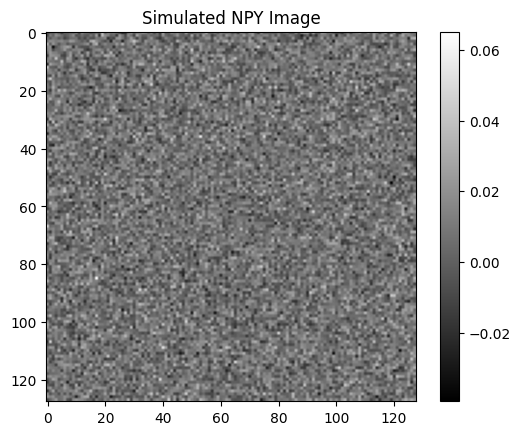

In [23]:
import matplotlib.pyplot as plt

data = np.load("./generated_images_npy/generated_image_0.npy")
data = np.squeeze(data)
plt.imshow(data, cmap='gray')
plt.colorbar()  # To show the scale of the image
plt.title("Simulated NPY Image")
plt.show()